# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch import nn

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data
from uncertainty import metrics

# Base Model

## Definitions

In [5]:
MODEL_ARC = 'ResNet50'#WideResNet ResNet101,ResNet18,ResNet34,ResNet50 CNN8
DATA = 'Cifar100'
NAME = f'{MODEL_ARC}_{DATA}_g'

In [6]:
VAL_SIZE = 0.1
data_params = {'train_batch_size': 128, 'validation_size': VAL_SIZE, 'test_batch_size': 100}

In [7]:
TRAIN = False

In [8]:
CREATE_DIR = True #If true, creates directories to save model (weights_path)
LIVE_PLOT = True #If True, plot* loss while training. If 'print', print loss per epoch
SAVE_CHECKPOINT = True #If True, save (and update) model weights for the best epoch (smallest validation loss)
SAVE_ALL = False #If True, saves weights and trainer at the end of training

In [9]:
data = torch_data.__dict__[DATA](data_dir = DATA_PATH,validation_as_train = True,params = data_params)
num_classes = data.n_classes
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA, 'Uncertainty_Regressor')

if CREATE_DIR and not os.path.isdir(weights_path):
    os.makedirs(weights_path)

Files already downloaded and verified
Files already downloaded and verified


## Upload Base Model

In [10]:
if not TRAIN:
    if DATA == 'ImageNet':
        weights = models.pretrained_models[model_class]
        pre_model = model_class(weights = weights).to(dev)
        data.transforms_test = weights.transforms()
    else:
        pre_model = model_class(num_classes = data.n_classes).to(dev)
        pre_model.load_state_dict(utils.upload_weights(weights_path))

## Train Base Model

In [11]:
N_EPOCHS_BASE = 200
loss_criterion = nn.CrossEntropyLoss()
risk_dict = None#{'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x,label,unc_type = unc.MCP_unc)}

In [12]:

if TRAIN:
    loss_criterion = nn.CrossEntropyLoss()
    pre_model = model_class(num_classes = data.n_classes).to(dev)
    optimizer = torch.optim.SGD(pre_model.parameters(), lr =0.1,momentum = 0.9,weight_decay = 5e-4,nesterov = True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS_BASE)
    model_trainer = TE.Trainer(pre_model,optimizer,loss_criterion, None,None,lr_scheduler = scheduler)
    model_trainer.fit(data.train_dataloader,N_EPOCHS_BASE, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)

## Base Model

In [13]:
pre_model.eval()
acc = TE.model_acc(pre_model,data.train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(pre_model,data.validation_dataloader)
print('Conjunto de validação: acc = ', acc)
acc = TE.model_acc(pre_model,data.test_dataloader)
print('Conjunto de teste: acc = ', acc)

Conjunto de treinamento: acc =  99.98222222222222
Conjunto de validação: acc =  77.06
Conjunto de teste: acc =  78.32


# Uncertainty Estimator

In [14]:
from uncertainty import MCP_unc, get_MCP, entropy
beta_range = np.around(np.append(np.arange(0.1,1.5,0.01),np.arange(1.5,5.1,0.05)),2)
outputs,labels = TE.accumulate_results(pre_model,data.test_dataloader)


## Model Definition

In [15]:
from torch.nn.functional import one_hot,softmax
class Uncertainty_Estimator(nn.Module):
    def __init__(self,model) -> None:
        super().__init__()
        self.Unc_Regressor = nn.Sequential(nn.Linear(data.n_classes,200),
                                        nn.ReLU(),
                                        #nn.Dropout(0.3),
                                        nn.Linear(200,100),
                                        nn.ReLU(),
                                        nn.Linear(100,100),
                                        nn.ReLU(),
                                        #nn.Dropout(0.3),
                                        nn.Linear(100,1), #globalpooling-max
                                        nn.Sigmoid())
        self.name = 'Unc_Estimator'
        self.base_model = model
        self.base_model.eval()
        utils.freeze_params(self.base_model)
    def forward(self,x):
        with torch.no_grad():
            logits = self.base_model(x)
            y_pred = TE.predicted_class(logits).view(-1)
            y = one_hot(y_pred,logits.size(-1))
        g = self.Unc_Regressor(logits)
        return y*g

class Temp_Model(nn.Module):
    def __init__(self, base_model,beta = 1.0) -> None:
        super().__init__()
        self.beta = beta
        self.base_model = base_model
    def forward(self):
        logits = self.base_model(x)
        return self.beta*logits

## Model Training

In [16]:
from uncertainty.metrics import acc_coverage

class Acc_Coverage_AUX():
    def __init__(self):
        self.y_pred = 0
        self.labels = 0
    def update(self,model,dataloader):
        self.y_pred, self.labels = TE.accumulate_results(model,dataloader)
    def get(self):
        return self.y_pred,self.labels
aux = Acc_Coverage_AUX()

class Acc_Coverage(nn.Module):
    def __init__(self,coverage,aux):
        super().__init__()
        self.coverage = coverage
        self.aux = aux
    def forward(self,model,dataloader):
        with torch.no_grad():
            if self.coverage <0.15:
                self.aux.update(model,dataloader)
            y_pred,labels = self.aux.get()
            g = torch.max(y_pred,dim=-1).values
            acc = acc_coverage(y_pred,labels,g,self.coverage)
            return torch.tensor(acc)

In [17]:
c_list = np.around(np.arange(0.1,1,0.1),1)
risk_dict = {f'Acc_{int(c*100)}':Acc_Coverage(c,aux) for c in c_list}
N_EPOCHS= 50
optim_params = {'lr':0.1,'momentum':0.9,'weight_decay':5e-4,'nesterov':True}

# Metrics Test

In [461]:
metrics_dict = {}

In [462]:
def normalized_entropy(y,**kwargs):
    return entropy(y,**kwargs)/np.log(data.n_classes)

### ECE Loss

In [463]:
from uncertainty.calibration import _ECELoss
loss_ece = _ECELoss(n_bins = 10)

In [464]:
eces = []
for beta in beta_range:
    y_pred = softmax(outputs*beta, dim=-1)
    eces.append(loss_ece(y_pred,labels).item())
metrics_dict['ECE'] = eces

### NLL (CrossEntropy)

In [465]:
loss_nll = nn.CrossEntropyLoss()

In [466]:
nlls = []
for beta in beta_range:
    y_pred = outputs*beta
    nlls.append(loss_nll(y_pred,labels).item())
#metrics_dict['NLL'] = nlls

### Brier

Matthews correlation coefficient

In [467]:
briers = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    briers.append(metrics.Brier(y_pred,labels).item())
#metrics_dict['Brier Score'] = briers

### BCE Loss

In [468]:
loss_bce = metrics.BCELoss_unc()

In [469]:
bces = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    bces.append(loss_bce(y_pred,labels).item())
metrics_dict['BCE'] = bces

### Mean Squared Loss

In [470]:
loss_mse = metrics.MSELoss_unc()

In [471]:
mses = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    mses.append(loss_mse(y_pred,labels).item())
#metrics_dict['MSE'] = mses

### AUROC

In [472]:
aurocs_mcp = []
aurocs_entropy = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    aurocs_mcp.append(metrics.AUROC(y_pred,labels,get_MCP(y_pred)).item())
    aurocs_entropy.append(metrics.AUROC(y_pred,labels,-entropy(y_pred)).item())
metrics_dict['AUROC'] = {'MCP':aurocs_mcp, 'Entropy': aurocs_entropy}

### AURC

In [473]:
aurcs_mcp = []
aurcs_entropy = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    aurcs_mcp.append(metrics.AURC(y_pred,labels,MCP_unc(y_pred)).item())
    aurcs_entropy.append(metrics.AURC(y_pred,labels,entropy(y_pred)).item())
metrics_dict['AURC'] = {'MCP':aurcs_mcp, 'Entropy': aurcs_entropy}

### Selective Loss

In [474]:
class error_loss(nn.Module):
    def __init__(self,reduction = 'mean'):
        super().__init__()
        self.reduction = reduction
    def forward(self,y_pred,y_true):
        error = torch.logical_not(TE.correct_class(y_pred,y_true)).float()
        if self.reduction == 'mean':
            error = torch.mean(error)
        elif self.reduction == 'sum':
            error = torch.sum(error)
        return error


In [475]:
class Selective_Loss(nn.Module):
    def __init__(self, loss_fn = error_loss):
        super().__init__()
        self.loss_fn = loss_fn(reduction = 'none')
    def forward(self,y_pred,y_true,unc):
        with torch.no_grad():
            loss = self.loss_fn(y_pred,y_true)
            unc = 1-unc
            loss *= unc / torch.sum(unc)
        return torch.sum(loss)
loss_sl = Selective_Loss()

In [476]:
selective_mcp = []
selective_entropy = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    selective_mcp.append(loss_sl(y_pred,labels,MCP_unc(y_pred)).item())
    selective_entropy.append(loss_sl(y_pred,labels,normalized_entropy(y_pred)).item())
metrics_dict['Selective Loss'] = {'MCP':selective_mcp, 'Entropy': selective_entropy}

#### SelectiveNet Optimization

In [477]:
class Selective_Net(Selective_Loss):
    def __init__(self,lambd,c, loss_fn = error_loss):
        super().__init__(loss_fn)
        self.lambd = lambd
        self.c = c
    def constraint(self,g):
        r = torch.mean(g)
        return self.lambd*torch.square(torch.nn.functional.relu(self.c-r))
    def forward(self,y_pred,y_true,unc):
        loss = super().forward(y_pred,y_true,unc)
        return loss + self.constraint(1-unc)
loss_sl = Selective_Net(32,0.8)       

In [478]:
selectiveNet_mcp = []
selectiveNet_entropy = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    selectiveNet_mcp.append(loss_sl(y_pred,labels,MCP_unc(y_pred)).item())
    selectiveNet_entropy.append(loss_sl(y_pred,labels,normalized_entropy(y_pred)).item())
metrics_dict['Selective Net Loss'] = {'MCP':selectiveNet_mcp, 'Entropy': selectiveNet_entropy}

#### Acc Coverage

In [484]:
AC_mcp = []
AC_entropy = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    AC_mcp.append(metrics.error_coverage(y_pred,labels,MCP_unc(y_pred), 0.8))
    AC_entropy.append(metrics.error_coverage(y_pred,labels,normalized_entropy(y_pred),0.8))
metrics_dict['Accuracy - 80% Coverage'] = {'MCP':AC_mcp, 'Entropy': AC_entropy}

### Soft Ranking

#### Differentiable Spearman

In [481]:
from fast_soft_sort.pytorch_ops import soft_rank, soft_sort
from scipy.stats import pearsonr
class Spearman(nn.Module):
    def __init__(self, regularization):
        super().__init__()
        self.reg = regularization
        self.error_loss = error_loss(reduction = 'none')
    def forward(self,y_pred,labels,unc):
        error = self.error_loss(y_pred,labels)
        soft_error = soft_rank(error.cpu().view(1,-1),regularization_strength=self.reg)
        soft_unc = soft_rank(unc.cpu().view(1,-1),regularization_strength=self.reg)
        spearman = torch.corrcoef(torch.cat((soft_error,soft_unc)))
        return -spearman[0,1]
spearman_loss = Spearman(1.0)

In [482]:
REG = 1.0
fss_mcp = []
fss_entropy = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    fss_mcp.append(spearman_loss(y_pred,labels,MCP_unc(y_pred)).item())
    fss_entropy.append(spearman_loss(y_pred,labels,entropy(y_pred)).item())
metrics_dict['Spearman'] = {'MCP':fss_mcp, 'Entropy': fss_entropy}

## Plot

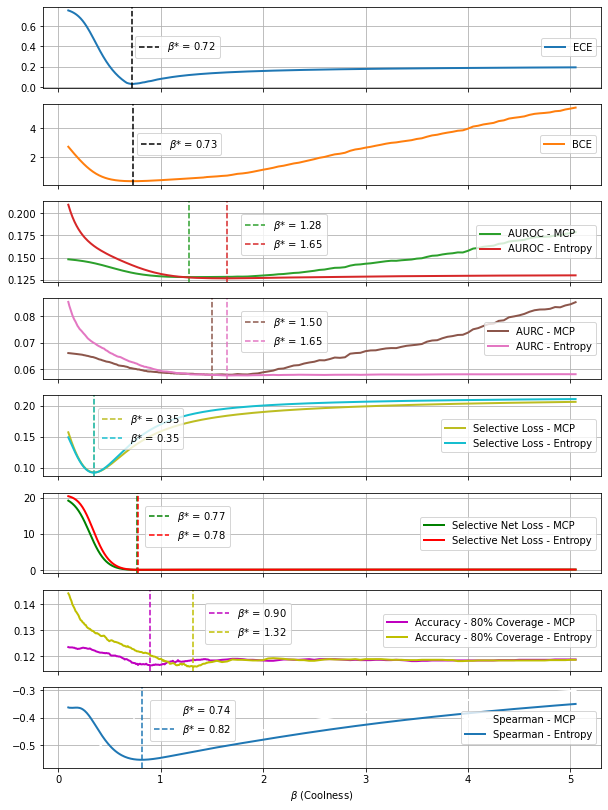

In [485]:
from itertools import chain
def add_plot_ax(ax,metric,name,color, beta_range = beta_range, vline_color = 'k'):
    beta_star = beta_range[np.argmin(metric)]
    ax.plot(beta_range,metric, label = name,color=color,linewidth = 2)
    ax.axvline(beta_star,linestyle = '--', color = vline_color)
    return beta_star

colors = chain(iter(matplotlib.colors.TABLEAU_COLORS.keys()),iter(matplotlib.colors.BASE_COLORS.keys()),iter(matplotlib.colors.TABLEAU_COLORS.keys()))
fig,axes = plt.subplots(len(metrics_dict),1, figsize = (10,14),sharex = True)
axes[-1].set_xlabel(r'$\beta$ (Coolness)')

idx = 0
for name,metric in metrics_dict.items():
    ax = axes[idx]
    color = next(colors)
    if isinstance(metric,dict):
        beta_stars = []
        for suffix,m in metric.items():
            beta_stars.append(add_plot_ax(ax,m,f'{name} - {suffix}',color,vline_color = color))
            color = next(colors)
        legend2 = ax.legend([ax.get_lines()[i] for i in [1,3]], [fr'$\beta$* = {beta_star:.2f}' for beta_star in beta_stars], 
                            loc='upper left',bbox_to_anchor=((max(beta_stars)+0.1)/np.max(beta_range), 0.9))
    else:      
        beta_star = add_plot_ax(ax,metric,name, color)
        legend2 = ax.legend([ax.get_lines()[1]], [fr'$\beta$* = {beta_star:.2f}'], loc='upper left',bbox_to_anchor=(beta_star*1.1/np.max(beta_range), 0.7))
    ax.add_artist(legend2)
    idx+=1
for ax in axes:
    ax.grid()
    ax.legend(loc = 'center right')

In [488]:
coverages = []
for beta in beta_range:
    y_pred = softmax(outputs*beta,-1)
    coverages.append(torch.mean(get_MCP(y_pred)).item())

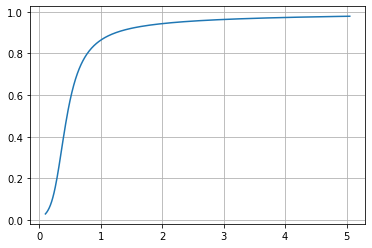

In [489]:
plt.plot(beta_range,coverages)
plt.grid()

In [ ]:
sample_1 = torch.log(torch.tensor([0.6,0.2,0.2]))
sample_2 = torch.log(torch.tensor([0.6,0.0001,0.3999]))
sample_3 = torch.log(torch.tensor([0.6,0.1,0.3]))
sample_4 = torch.log(torch.tensor([0.8,0.15,0.05]))
sample_5 = torch.log(torch.tensor([0.4,0.3,0.3]))
sample_6 = torch.log(torch.tensor([0.95,0.04,0.01]))
sample_7 = torch.log(torch.tensor([0.94,0.04,0.02]))
samples = torch.stack((sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7))
samples

In [ ]:
softmax(samples,-1)

In [ ]:
mcps = []
ents = []
for beta in beta_range:
    y = softmax(samples*beta,-1)
    y = torch.sort(y,-1,descending = True).values
    mcps.append(get_MCP(y).tolist())
    ents.append(entropy(y).tolist())
mcps= torch.tensor(mcps)
ents = torch.tensor(ents)

In [ ]:
from ipywidgets import interactive,IntSlider
%matplotlib inline
fig = plt.figure()

def plot_RC_widget(beta=1.0):
    for i,s in enumerate(samples):
        ax = axes[i]
        y = softmax(s,-1)
        y = torch.sort(y,-1,descending = True).values
        ax.bar(y,1,width = 0.05,color = c)
    
    fig.canvas.draw_idle()
    plt.ylim(0,0.22)
    plt.grid()
    plt.legend()
    plt.show()
interactive_plot = interactive(plot_RC_widget,beta=(0.1,5,0.05))
interactive_plot

In [ ]:
fig,axes = plt.subplots(samples.size(0),1, figsize = (9,14),sharex = True)
axes[-1].set_xlabel(r'p')
c = ['red', 'yellow', 'blue', 'orange']
for i,s in enumerate(samples):
    ax = axes[i]
    y = softmax(s,-1)
    y = torch.sort(y,-1,descending = True).values
    ax.bar(y,1,width = 0.05,color = c)

    ax.set_title(f'Sample {i+1}')
    
for ax in axes:
    ax.grid()

In [ ]:
fig,axes = plt.subplots(2,1, figsize = (9,7),sharex = True)
axes[-1].set_xlabel(r'$\beta$ (Coolness)')
for i in range(samples.size(0)):
    axes[0].plot(beta_range,mcps[:,i], label = f'Sample {i+1}')
    
    
    axes[1].plot(beta_range,ents[:,i], label = f'Sample {i+1}')

axes[0].set_title('MCP')
axes[1].set_title('Entropy')
for ax in axes:
    ax.grid()
    ax.legend()

In [ ]:
fig,axes = plt.subplots(2,1, figsize = (9,7),sharex = True)
axes[-1].set_xlabel(r'$\beta$ (Coolness)')


axes[0].plot(beta_range,mcps[:,-1]-mcps[:,-2], label = f'Sample {i+1}')


axes[1].plot(beta_range,ents[:,-1]-ents[:,-2], label = f'Sample {i+1}')

axes[0].set_title('MCP')
axes[1].set_title('Entropy')
for ax in axes:
    ax.grid()
    ax.legend()

In [ ]:
ents[:,-2][-1]

In [ ]:
mcps[:,-1]-mcps[:,-2]

In [ ]:
ents[:,-1]-ents[:,-2]

In [ ]:
y = softmax(samples[-2:]*4.5,-1)

In [ ]:
y

In [ ]:
y.numpy()[0,0]

In [ ]:
y.numpy()[0,0]

In [ ]:
y[0,0].item()

In [ ]:
y[1,0].item()

In [ ]:
y.numpy()[1,0]

In [ ]:
type(y[1,0].item())